<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Spectral Leak Subtraction Notebook #

**Author**: David Law, AURA Associate Astronomer, MIRI branch
<br>
**Last Updated**: November 13, 2023
<br>
**Pipeline Version**: 1.12.5
<br>
<br>
**Changes**:<br>
Nov 13 2023: Bugfix to wavelength interpolation

The purpose of this notebook is to apply a correction for the MRS spectral leak in which second-order light from 6 microns (Ch1B) enters the 12 micron (Ch3A) waveband.  This is performed by multipying an input Ch1B spectrum by a relative response reference file and subtracting the resulting leak signal from the Ch3A spectrum.  Due to the different fields of view of Ch1B and Ch3A this correction can only be applied to spectra extracted from point sources.

This notebook is set up assuming fixed paths to the Ch1B and Ch3A spectra, and will write out the corrected Ch3A spectrum to a new file.

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Configuration <a class="anchor" id="intro"></a>
------------------

In [1]:
# Set parameters to be changed here.
# It should not be necessary to edit cells below this in general unless modifying the correction.

# Pipeline spectrum for Ch1B
input_ch1b = 'Level3_ch1-medium_x1d.fits'

# Pipeline spectrum for Ch3A
input_ch3a = 'Level3_ch3-short_x1d.fits'

# Output correction spectrum for Ch3A
output_ch3a = 'Level3_ch3-short_leakcor_x1d.fits'


do_plot = True # Make a plot of the spectra?
write_new = True # Write out new file?

<hr style="border:1px solid gray"> </hr>

2.<font color='white'>-</font>Imports and setup <a class="anchor" id="import"></a>
------------------

In [2]:
from astropy.io import fits
from astropy.utils.data import download_file
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import copy

In [3]:
# Download leak reference file from Box
reffile='https://stsci.box.com/shared/static/bywmjancltl0yqn6q97w3rgtq0m4xbqa.fits'
leak_ref_file = download_file(reffile, cache=True)
leak_ref=(fits.open(leak_ref_file))['LEAKCOR'].data
leak_wave=leak_ref['WAVELENGTH']
leak_percent=leak_ref['FRAC_LEAK']

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Apply correction<a class="anchor" id="apply"></a>
------------------

In [4]:
ch1b=fits.open(input_ch1b)
ch3a=fits.open(input_ch3a)

wave1b=ch1b[1].data['WAVELENGTH']
spec1b=ch1b[1].data['FLUX']

wave3a=ch3a[1].data['WAVELENGTH']
spec3a=ch3a[1].data['FLUX']

In [5]:
# Spectral leak vector
leak = np.interp(wave3a,2*wave1b,spec1b) * np.interp(wave3a,leak_wave,leak_percent)

# Correct the data
spec3a_corr = spec3a - leak

In [6]:
# Write result to disk?
if write_new:
    hdu=copy.deepcopy(ch3a)
    hdu[1].data['FLUX']=spec3a_corr
    hdu.writeto(output_ch3a,overwrite=True)
    hdu.close()
    print('Wrote out new file.')

Wrote out new file.


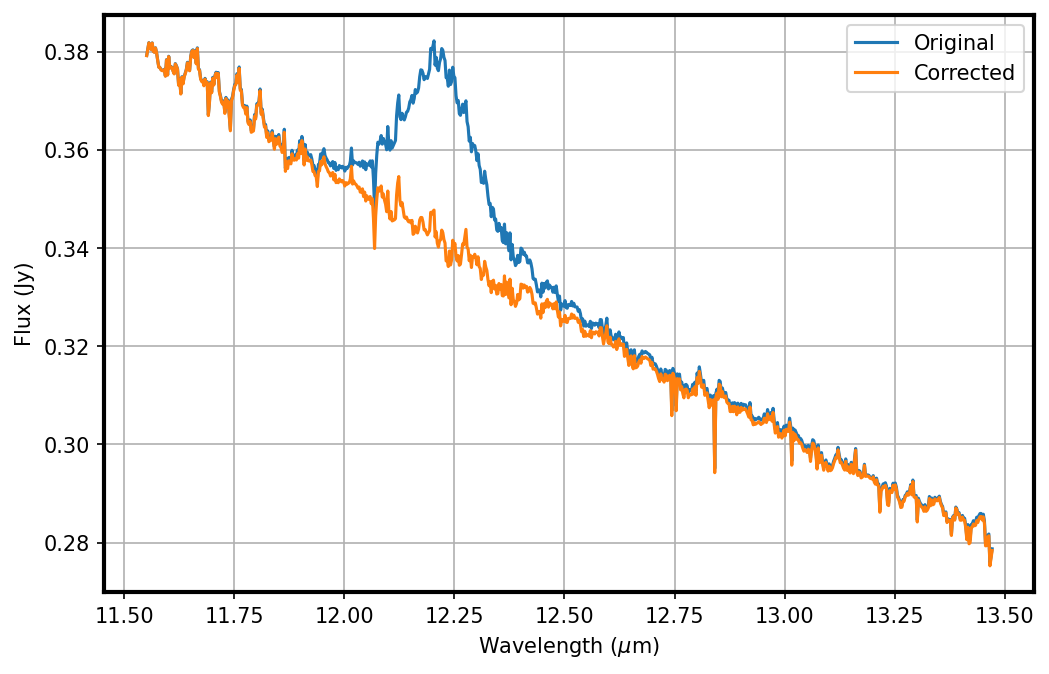

In [7]:
# Plot results?
if do_plot:
    rc('axes', linewidth=2)
    fig,ax = plt.subplots(1,1, figsize=(8,5),dpi=150)

    plt.plot(wave3a,spec3a,label='Original')
    plt.plot(wave3a,spec3a_corr,label='Corrected')
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel('Flux (Jy)')
    plt.grid()
    plt.legend()

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://www.stsci.edu/~dlaw/stsci_logo.png" alt="stsci_logo" width="200px"/> 